## Install dependepncies

In [1]:
!pip install pyspark
!pip install graphframes

In [4]:
import pyspark
from delta import configure_spark_with_delta_pip

# Prepare the Spark builder with Delta extensions and set extra packages for GraphFrames
builder = pyspark.sql.SparkSession.builder.appName("project3") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

# Start Spark with the extra GraphFrames package (version must match your Spark/Scala version)
spark = configure_spark_with_delta_pip(builder, extra_packages=["graphframes:graphframes:0.8.4-spark3.5-s_2.12"]).getOrCreate()
spark.conf.set("spark.sql.shuffle.partitions", spark._sc.defaultParallelism)
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark.conf.set("spark.sql.repl.eagerEval.truncate", 500)

## Load the data

In [5]:
df = spark.read.option("header", "true").csv("input/2009.csv")
df.printSchema()

root
 |-- FL_DATE: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: string (nullable = true)
 |-- DEP_TIME: string (nullable = true)
 |-- DEP_DELAY: string (nullable = true)
 |-- TAXI_OUT: string (nullable = true)
 |-- WHEELS_OFF: string (nullable = true)
 |-- WHEELS_ON: string (nullable = true)
 |-- TAXI_IN: string (nullable = true)
 |-- CRS_ARR_TIME: string (nullable = true)
 |-- ARR_TIME: string (nullable = true)
 |-- ARR_DELAY: string (nullable = true)
 |-- CANCELLED: string (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: string (nullable = true)
 |-- CRS_ELAPSED_TIME: string (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: string (nullable = true)
 |-- AIR_TIME: string (nullable = true)
 |-- DISTANCE: string (nullable = true)
 |-- CARRIER_DELAY: string (nullable = true)
 |-- WEATHER_DELAY: strin

## Data Cleansing

In [4]:
from pyspark.sql.functions import col

# Cast CANCELLED to float
df = df.withColumn("CANCELLED", col("CANCELLED").cast("float"))

# Filter on 0.0
df_clean = (
    df
    .filter(col("CANCELLED") == 0.0)
    .dropna(subset=["ORIGIN", "DEST"])
    .filter(col("ORIGIN") != col("DEST"))
)
df_clean.show()

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|

### Create Graph

In [5]:
from graphframes import GraphFrame

vertices = df_clean.select(col("ORIGIN").alias("id")) \
    .union(df_clean.select(col("DEST").alias("id"))) \
    .distinct()

display(vertices)

id
DCA
GSO
IAH
JAX
OKC
CHS
ABQ
IND
CLT
CVG


In [6]:
edges = df_clean.select(
    col("ORIGIN").alias("src"),
    col("DEST").alias("dst")
)

display(edges)

src,dst
DCA,EWR
EWR,IAD
EWR,DCA
DCA,EWR
IAD,EWR
ATL,EWR
CLE,ATL
DCA,EWR
EWR,DCA
EWR,DCA


In [7]:
graph = GraphFrame(vertices, edges)

vertices.cache()
edges.cache()

display(graph)

GraphFrame(v:[id: string], e:[src: string, dst: string])

## Query 1: Compute different statistics

In [8]:
from pyspark.sql.functions import count

# Compute out-degree: count flights leaving each airport.
out_degree = edges.groupBy("src").agg(count("*").alias("out_degree")) \
                  .withColumnRenamed("src", "id")

# Compute in-degree: count flights arriving at each airport.
in_degree = edges.groupBy("dst").agg(count("*").alias("in_degree")) \
                 .withColumnRenamed("dst", "id")

# Combine the results with vertices to include all airports,
degree_df = vertices.join(in_degree, on="id", how="left") \
                    .join(out_degree, on="id", how="left") \
                    .na.fill(0) \
                    .withColumn("total_degree", col("in_degree") + col("out_degree"))

# Display the degree statistics
display(degree_df)

id,in_degree,out_degree,total_degree
DCA,78016,77900,155916
GSO,9869,9856,19725
IAH,180874,180960,361834
JAX,28593,28534,57127
OKC,21741,21680,43421
CHS,12659,12649,25308
ABQ,35419,35393,70812
IND,37726,37691,75417
CLT,115338,115521,230859
CVG,56462,56634,113096


### Triangle count

In [9]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col

# triangle count, undirected
def triangleCount(graph):
    # Normalize edges so that each edge is stored in one direction.
    edges = graph.edges.select(
        F.least("src", "dst").alias("src"), 
        F.greatest("src", "dst").alias("dst")
    ).distinct()

    # 1. Find neighbors for each node.
    neighbors = edges.groupBy("src").agg(F.collect_set("dst").alias("neighbors"))

    # 2. Join neighbors with edges to find pairs of neighbors for a node.
    neighbor_pairs = neighbors.alias("n1").join(
        edges.alias("e"), col("n1.src") == col("e.src")
    ).join(
        neighbors.alias("n2"), col("e.dst") == col("n2.src")
    ).select(
        col("n1.src").alias("node1"),
        col("n1.neighbors").alias("neighbors1"),
        col("n2.src").alias("node2"),
        col("n2.neighbors").alias("neighbors2")
    )

    # 3. Find intersections of neighbor sets and count.
    triangles = neighbor_pairs.withColumn(
        "intersection_size", F.size(F.array_intersect("neighbors1", "neighbors2"))
    ).select("node1", "node2", "intersection_size")

    # 4. Group by node1 to calculate triangles.
    triangle_counts = triangles.groupBy("node1").agg(
        F.sum("intersection_size").alias("triangleCount")
    ).select(col("node1").alias("vertex"), "triangleCount")

    return triangle_counts

# Usage
triangle_counts = triangleCount(graph)
triangle_counts.show()

+------+-------------+
|vertex|triangleCount|
+------+-------------+
|   ABQ|          311|
|   ANC|          122|
|   BDL|          283|
|   BOS|          779|
|   BTV|           26|
|   BNA|          635|
|   CHS|           65|
|   CLT|          695|
|   AZO|            6|
|   CAE|           35|
|   CVG|          787|
|   DCA|          411|
|   BUR|           49|
|   BMI|           15|
|   CLL|            0|
|   AVL|           20|
|   DSM|           47|
|   BGM|            0|
|   DAL|           49|
|   EGE|           25|
+------+-------------+
only showing top 20 rows



In [10]:
# Example of using from GraphFrames
gf_trianglecount = graph.triangleCount()
display(gf_trianglecount)

count,id
673,DCA
54,GSO
1338,IAH
342,JAX
165,OKC
90,CHS
311,ABQ
612,IND
1049,CLT
1260,CVG


## Query 2: Total number of triangles

In [11]:
# Total triangle count using our implementation
total_triangles = triangle_counts.agg(F.sum("triangleCount").alias("total")).collect()[0]["total"]
print("Total number of triangles:", total_triangles)

Total number of triangles: 15991


In [12]:
# Total triangle count counted from GraphFrames implementation
total_sum_gf = gf_trianglecount.agg(F.sum("count").alias("total")).collect()[0]["total"]

# Each triangle is counted 3 times (once per vertex), so divide by 3.
total_triangles_gf = total_sum_gf / 3

print("Total number of triangles:", total_triangles_gf)

Total number of triangles: 15991.0


## Query 3: Closeness Centrality

In [13]:
from pyspark.sql.functions import lit, col, when
from pyspark.sql import DataFrame

def compute_closeness_centrality(vertices, edges, max_depth=10):
    closeness_scores = []

    vertex_ids = [row["id"] for row in vertices.select("id").collect()]

    for source in vertex_ids:
        print(f"Processing: {source}")  # debug log

        visited = vertices.withColumn("distance", when(col("id") == source, lit(0)))
        frontier = visited.filter(col("id") == source)

        depth = 0
        while frontier.count() > 0 and depth < max_depth:
            print(f"Depth: {depth}, Frontier size: {frontier.count()}")  # debug log

            next_frontier = frontier.join(edges, frontier["id"] == edges["src"]) \
                                    .select(edges["dst"].alias("id")) \
                                    .distinct()

            next_frontier = next_frontier.join(visited, "id", "left_anti") \
                                         .withColumn("distance", lit(depth + 1))

            visited = visited.union(next_frontier).distinct()
            frontier = next_frontier
            depth += 1

        reachable = visited.filter((col("id") != source) & col("distance").isNotNull())
        reachable_count = reachable.count()

        if reachable_count > 0:
            total_distance = reachable.agg({"distance": "sum"}).collect()[0][0]
            avg_distance = total_distance / reachable_count
            closeness = 1 / avg_distance if avg_distance > 0 else 0
        else:
            closeness = 0

        closeness_scores.append((source, closeness))

    return spark.createDataFrame(closeness_scores, ["id", "closeness_centrality"])


In [14]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col

import gc
import time

def compute_all_closeness_in_batches(vertices: DataFrame, edges: DataFrame, batch_size: int = 10, max_depth: int = 3) -> DataFrame:
    from pyspark.sql.functions import col

    airport_ids = [row["id"] for row in vertices.collect()]
    total = len(airport_ids)
    all_results = []

    for i in range(0, total, batch_size):
        print(f"\n🧮 Batch {i // batch_size + 1}: Processing airports {i} to {min(i + batch_size, total)}...")

        batch_ids = airport_ids[i:i + batch_size]
        batch_vertices = vertices.filter(col("id").isin(batch_ids))

        # Try/catch for robustness
        try:
            batch_result = compute_closeness_centrality(batch_vertices, edges, max_depth=max_depth)
            all_results.append(batch_result)
        except Exception as e:
            print(f"❌ Error in batch {i // batch_size + 1}: {e}")
        
        # Give Spark a break (crucial in Docker)
        spark.catalog.clearCache()
        gc.collect()
        time.sleep(2)

    # Combine results safely
    if not all_results:
        return spark.createDataFrame([], schema="id STRING, closeness_centrality DOUBLE")

    combined = all_results[0]
    for df in all_results[1:]:
        combined = combined.union(df)

    return combined




In [15]:
closeness_df_batched = compute_all_closeness_in_batches(vertices.limit(5), edges, batch_size=5, max_depth=2)
display(closeness_df_batched.orderBy(col("closeness_centrality").desc()))


🧮 Batch 1: Processing airports 0 to 5...
Processing: DCA
Depth: 0, Frontier size: 1
Depth: 1, Frontier size: 46
Processing: GSO
Depth: 0, Frontier size: 1
Depth: 1, Frontier size: 10
Processing: IAH
Depth: 0, Frontier size: 1
Depth: 1, Frontier size: 98
Processing: JAX
Depth: 0, Frontier size: 1
Depth: 1, Frontier size: 28
Processing: OKC
Depth: 0, Frontier size: 1
Depth: 1, Frontier size: 19


id,closeness_centrality
IAH,0.6033755274261604
DCA,0.5467479674796748
JAX,0.5318181818181819
OKC,0.518664047151277
GSO,0.5114155251141552


In [16]:
print("Total edges:", edges.count())
edges.show(5)


Total edges: 6342300
+---+---+
|src|dst|
+---+---+
|DCA|EWR|
|EWR|IAD|
|EWR|DCA|
|DCA|EWR|
|IAD|EWR|
+---+---+
only showing top 5 rows



In [17]:
from pyspark.sql.functions import length, trim

# Check for edge values not in vertices
edges_not_in_vertices = edges.filter(~col("src").isin([row["id"] for row in vertices.collect()]) |
                                     ~col("dst").isin([row["id"] for row in vertices.collect()]))

print("Edges with unmatched nodes:", edges_not_in_vertices.count())
edges_not_in_vertices.show(5)

Edges with unmatched nodes: 0
+---+---+
|src|dst|
+---+---+
+---+---+



In [18]:
from collections import deque

airport = "ATL"  # a well-connected airport

frontier = deque([airport])
visited = set()
depth = 0
max_depth = 3

while frontier and depth < max_depth:
    next_level = deque()
    for node in frontier:
        neighbors = edges.filter(edges["src"] == node).select("dst").rdd.flatMap(lambda x: x).collect()
        for n in neighbors:
            if n not in visited:
                next_level.append(n)
                visited.add(n)
    frontier = next_level
    depth += 1

print(f"From {airport}, reachable nodes within depth {max_depth}: {len(visited)}")

From ATL, reachable nodes within depth 3: 296


In [19]:
del count

## Query 4: PageRank

In [9]:
import pyspark.sql.functions as F

spark.sparkContext.setCheckpointDir("/tmp/spark-checkpoints")

# assign the default rank 1 to each vertex
ranks = vertices.withColumn("rank", F.lit(1.0))
ranks = ranks.checkpoint(eager=True)
N = vertices.count()

# run algorithm for 10 iterations
iterations = 10
# damping factor
damping = 0.85

for i in range (iterations):
    # calculate the contributions each vertex receives
    contributions = (edges.join(ranks, edges.src == ranks.id)
                     .join(out_degree, edges.src == out_degree.id) # get all the vertices and number of outgoing edges
                     .select(
                         edges.dst.alias("id"),
                         (ranks["rank"] / out_degree["out_degree"]).alias("contrib") # contribution the destination vertex receives
                     ))

    # sum up contribution each node received 
    grouped_contributions = (contributions.groupBy("id")
              .agg(F.sum("contrib").alias("sum_contrib"))
              .select(
                  col("id"),
                  (((1 - damping) / N) + damping * col("sum_contrib")).alias("rank") # apply pagerank formula
              ))

    # assigm default rank to the nodes that did not receive any contributions
    dangling = vertices.join(grouped_contributions.select("id"), "id", "left_anti") \
                       .withColumn("rank", F.lit((1 - damping) / N))

    # update the ranks and make checkpoint to prevent OOM errors
    new_ranks = grouped_contributions.unionByName(dangling)
    ranks = new_ranks.checkpoint(eager=True)


# Show final ranks
ranks.orderBy("rank", ascending=False).show()
    

+---+------------------+
| id|              rank|
+---+------------------+
|ATL|3.7724214047743256|
|ORD| 2.822163405211109|
|DFW| 2.392312157095149|
|DEN|2.1695373735711567|
|LAX| 1.784720050983769|
|PHX|1.6960019405941815|
|IAH| 1.665641662294651|
|LAS|1.4256303772642642|
|DTW|1.3825766799908714|
|SFO| 1.263557563528792|
|SLC|1.2324043976427392|
|MCO|1.1052788152888853|
|MSP|1.1032846162567427|
|JFK|1.0775584148475894|
|EWR|1.0644052990426738|
|CLT| 1.058684600431682|
|SEA|0.9956368619900284|
|BOS|0.9898443507656947|
|BWI|0.9173156921665774|
|LGA|0.8843547862273229|
+---+------------------+
only showing top 20 rows



### Visual Representation of PageRank results

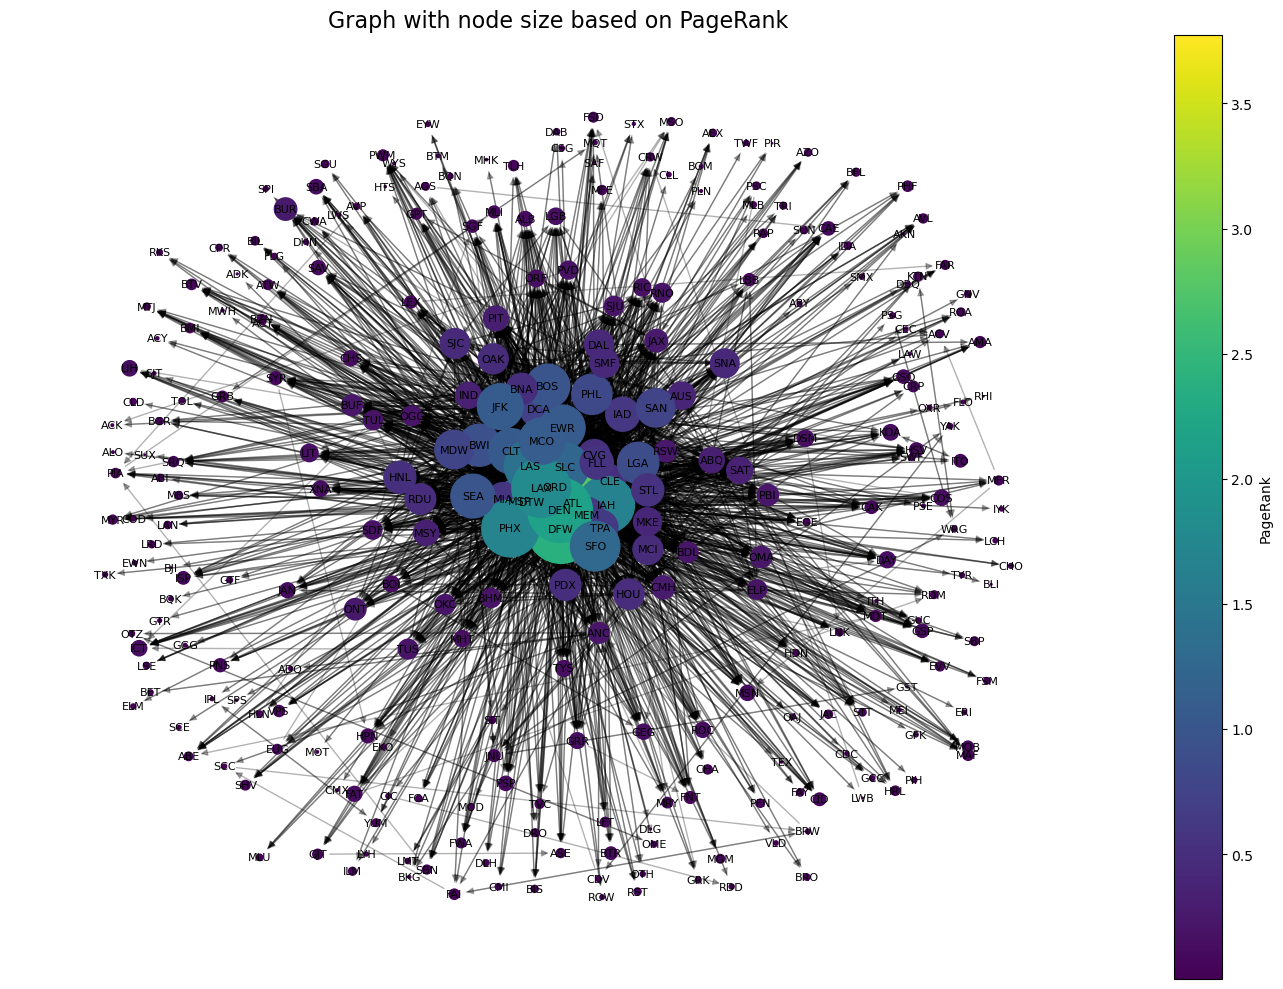

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the graph
ranks_pd = ranks.toPandas()

# Collect edges as a list of tuples
edges_list = edges.select("src", "dst").rdd.map(tuple).collect()  

# create graph from edges
G = nx.DiGraph()  
G.add_edges_from(edges_list)  

# add pagerank attribute
pagerank_dict = dict(zip(ranks_pd["id"], ranks_pd["rank"]))
nx.set_node_attributes(G, pagerank_dict, "pagerank")

# position nodes using Fruchterman-Reingold force-directed algorithm
# https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
pos = nx.spring_layout(G, k=0.5, iterations=20)
# pos = nx.random_layout(G)

# get pagerank of each node and assign size for each rank
node_ranks = [pagerank_dict.get(node, 0) for node in G.nodes()]
node_sizes = [r * 1000 for r in node_ranks]

# select color map and normalize values
cmap = plt.cm.viridis
norm = plt.Normalize(min(node_ranks), max(node_ranks))
node_colors = [cmap(norm(rank)) for rank in node_ranks]

# Create figure and axes explicitly
fig, ax = plt.subplots(figsize=(14, 10))

# Draw nodes/edges/labels
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, ax=ax)
nx.draw_networkx_edges(G, pos, alpha=0.3, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("PageRank")

ax.set_title("Graph with node size based on PageRank", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()


# Query 5 - Find the group of the most connected airports

In [12]:
from pyspark.sql.functions import col, explode, array, countDistinct

# Select only origin and destination
routes_df = df.select("ORIGIN", "DEST").distinct()

# Create bidirectional edges (to count connections for both ORIGIN and DEST)
airport_edges = routes_df.selectExpr("ORIGIN as airport", "DEST as connection") \
    .union(routes_df.selectExpr("DEST as airport", "ORIGIN as connection"))

# Count unique connections per airport
connected_airports = airport_edges.groupBy("airport") \
    .agg(countDistinct("connection").alias("num_connections"))

# Order by number of connections to find the most connected group
most_connected_airports = connected_airports.orderBy(col("num_connections").desc())

# Show the top N most connected airports
most_connected_airports.show()

+-------+---------------+
|airport|num_connections|
+-------+---------------+
|    ATL|            165|
|    ORD|            141|
|    DFW|            134|
|    DTW|            124|
|    MSP|            119|
|    DEN|            118|
|    IAH|            102|
|    SLC|             97|
|    CVG|             90|
|    MEM|             85|
|    PHX|             83|
|    EWR|             81|
|    LAX|             79|
|    LAS|             79|
|    CLT|             76|
|    MCO|             76|
|    SFO|             70|
|    IAD|             66|
|    JFK|             65|
|    BWI|             62|
+-------+---------------+
only showing top 20 rows

